In [18]:
# BASIC DS LIBS
import openpyxl
import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt

# FILE IO LIBS
import os 
from os.path import join 

# GEOSPATIAL LIBS
import time
import geopy
from osgeo import gdal
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderServiceError


# PLOT LIBS
import plotly.express as px 
from plotly.offline import plot
import plotly.graph_objects as go
from shapely.geometry import Point
from plotly.subplots import make_subplots


In [19]:
# IMPORT DATA
hunger_data = pd.read_csv(r'data/foodlink_data.csv')
mealmap_data = pd.read_excel(r'data/MMG2022_2020-2019Data_ToShare.xlsx')
gun_data = pd.read_csv(r'data/Rochester_NY_Shooting_Victims.csv')

In [20]:
gun_data.head()
print(gun_data.columns)
print(gun_data.count())

Index(['X', 'Y', 'ID', 'Case_Number', 'Address', 'Occurred_Date',
       'Occurred_Month', 'Occurred_Year', 'Crime_Type', 'Multiple_Shooting',
       'Gender', 'Race', 'Ethnicity', 'Victim_Age', 'Victim_Age_Band',
       'Latitude', 'Longitude', 'ObjectId'],
      dtype='object')
X                    4679
Y                    4679
ID                   4679
Case_Number          4679
Address              4679
Occurred_Date        4679
Occurred_Month       4679
Occurred_Year        4679
Crime_Type           4679
Multiple_Shooting    4679
Gender               4679
Race                 4679
Ethnicity            4679
Victim_Age           4679
Victim_Age_Band      4679
Latitude             4679
Longitude            4679
ObjectId             4679
dtype: int64


In [21]:
# GUN DATA CLEANING
gun_extras = gun_data[[  'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Crime_Type',
                        'Multiple_Shooting'
]]

gun_data = gun_data.drop(columns=[
                        'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Crime_Type',
                        'Multiple_Shooting'
                        ])

gun_data = gun_data.loc[gun_data['Occurred_Year'].isin([2022,2023])]                        
print(gun_data.info())  # to check for any missing values
print("                           GUN VIOLENCE DATA AFTER DATA CLEANING")
gun_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 436
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              137 non-null    float64
 1   Y              137 non-null    float64
 2   Address        137 non-null    object 
 3   Occurred_Date  137 non-null    object 
 4   Occurred_Year  137 non-null    int64  
 5   Latitude       137 non-null    float64
 6   Longitude      137 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.6+ KB
None
                           GUN VIOLENCE DATA AFTER DATA CLEANING


,X,Y,Address,Occurred_Date,Occurred_Year,Latitude,Longitude
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,43.184163,-77.610890
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,43.181793,-77.598893
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,43.142970,-77.630378
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,43.167216,-77.580628
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,43.162394,-77.641972


In [22]:
# HUNGER DATA
hunger_data.columns = ['Zip_code', 'Latitude', 'Longitude', 'Food Insecurity Rate']

# NARROW DOWN DATA TO JUST ROCHESTER AREAS
roc_zip = list(range(14604, 14624))
roc_zip.append(14626)
roc_zip.append(14627)
roc_zip.append(14642)
hunger_data = hunger_data.loc[hunger_data['Zip_code'].isin(roc_zip)]

print(hunger_data.info())   # to check for missing values

print("     FOOD INSECURITY DATA AFTER DATA CLEANING")
hunger_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 124 to 145
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Zip_code              20 non-null     int64  
 1   Latitude              20 non-null     float64
 2   Longitude             20 non-null     float64
 3   Food Insecurity Rate  20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 800.0 bytes
None
     FOOD INSECURITY DATA AFTER DATA CLEANING


,Zip_code,Latitude,Longitude,Food Insecurity Rate
124,14626,43.2141,-77.7135,0.094
127,14623,43.0881,-77.6425,0.167
128,14622,43.2138,-77.5569,0.080
129,14621,43.1863,-77.6018,0.298
130,14620,43.1291,-77.6065,0.187


In [23]:
# GET ALL RELEVANT ZIPCODES FROM LAT/LON COORDINATES

gun_long = gun_data['Longitude'].tolist()
gun_lat = gun_data['Latitude'].tolist()
zipcodes = []
geolocator = Nominatim(user_agent='myapplication')

def reverse_geocode_with_retries(geolocator, lat, long, max_retries=3, delay=5):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.reverse((lat, long), timeout=10)
            return location
        except GeocoderServiceError as e:
            retries += 1
            if retries < max_retries:
                time.sleep(delay)
            else:
                raise e

In [24]:
for i in range(len(gun_lat)):
    location = reverse_geocode_with_retries(geolocator, gun_lat[i], gun_long[i])
    address = location.raw['address']
    zipcodes.append(address.get('postcode'))

In [30]:
gun_data = gun_data.reset_index(drop=True)
zipcode_2022_23 = pd.Series(zipcodes)
gun_data['Zip_code'] = zipcode_2022_23

In [31]:
gun_data = gun_data.groupby(['Zip_code'])['X'].count().reset_index(name="count")

In [32]:
# ADD MISSING ZIP CODES
allzip = list(range(14604, 14624))
allzip.append(14626)
allzip.append(14627)
allzip.append(14642)

zip_gun = zipcodes
zip_gun = {int(x) for x in zip_gun}
zip_noinclude = list(set(allzip) - set(zip_gun))

for i in range(len(zip_noinclude)):
    gun_data = gun_data.append({'Zip_code': zip_noinclude[i], 'count': 0}, ignore_index=True)

gun_data.rename(columns={'count': 'Number of Shootings'}, inplace=True)

gun_data.head()

C:\Users\jcof2\AppData\Local\Temp\ipykernel_13072\1608056667.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\jcof2\AppData\Local\Temp\ipykernel_13072\1608056667.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\jcof2\AppData\Local\Temp\ipykernel_13072\1608056667.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\jcof2\AppData\Local\Temp\ipykernel_13072\1608056667.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\jcof2\AppData\Local\Temp\ipykernel_13072\1608056667.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

,Zip_code,Number of Shootings
0,14604,2
1,14605,10
2,14606,11
3,14608,21
4,14609,19


In [33]:
gun_data['Zip_code'] = gun_data['Zip_code'].astype(int)
full_data = pd.merge(hunger_data, gun_data, on='Zip_code')
print("                         FULL DATA SET")
full_data.head(10)

                         FULL DATA SET


,Zip_code,Latitude,Longitude,Food Insecurity Rate,Number of Shootings
0,14626,43.2141,-77.7135,0.094,0
1,14623,43.0881,-77.6425,0.167,0
2,14622,43.2138,-77.5569,0.080,0
3,14621,43.1863,-77.6018,0.298,34
4,14620,43.1291,-77.6065,0.187,0
5,14619,43.1363,-77.6493,0.281,4
6,14618,43.1126,-77.5555,0.077,0
7,14617,43.2242,-77.5951,0.073,0
8,14616,43.2340,-77.6550,0.106,0
9,14615,43.2049,-77.6550,0.190,2


In [34]:
full_data['Food Insecurity Rate'] = (full_data['Food Insecurity Rate']-full_data['Food Insecurity Rate'].min())/(full_data['Food Insecurity Rate'].max()-full_data['Food Insecurity Rate'].min())
full_data['Gun Violence Rate'] = (full_data['Number of Shootings']-full_data['Number of Shootings'].min())/(full_data['Number of Shootings'].max()-full_data['Number of Shootings'].min())

print("                   Scaled Dataset Using Min-Max Normalization")
full_data.head(10)

                   Scaled Dataset Using Min-Max Normalization


,Zip_code,Latitude,Longitude,Food Insecurity Rate,Number of Shootings,Gun Violence Rate
0,14626,43.2141,-77.7135,0.063063,0,0.000000
1,14623,43.0881,-77.6425,0.282282,0,0.000000
2,14622,43.2138,-77.5569,0.021021,0,0.000000
3,14621,43.1863,-77.6018,0.675676,34,1.000000
4,14620,43.1291,-77.6065,0.342342,0,0.000000
5,14619,43.1363,-77.6493,0.624625,4,0.117647
6,14618,43.1126,-77.5555,0.012012,0,0.000000
7,14617,43.2242,-77.5951,0.000000,0,0.000000
8,14616,43.2340,-77.6550,0.099099,0,0.000000
9,14615,43.2049,-77.6550,0.351351,2,0.058824


y = 0.75017 * x + -3.91968 * x^2 + 14.69200


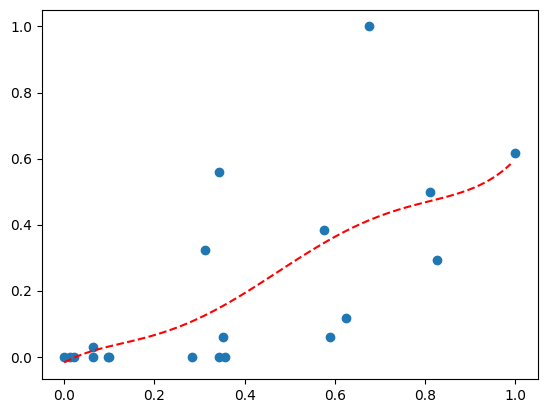

In [35]:
from scipy.optimize import curve_fit
from matplotlib import pyplot
from numpy import arange
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
popt, _ = curve_fit(objective, full_data["Food Insecurity Rate"], full_data['Gun Violence Rate'])
# summarize the parameter values
a, b,c,d,e,f = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
pyplot.scatter(full_data["Food Insecurity Rate"], full_data['Gun Violence Rate'])
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(full_data["Food Insecurity Rate"]), max(full_data["Food Insecurity Rate"]), 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b,c,d,e,f)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()